# Modelo de BETO (BERT en español)

El modelo de BERT se ha adaptado a diferentes lenguajes, entre ellos el español (Cañete et al., 2020). El modelo de BETO es una versión de BERT pre-entrenado en español. Este modelo permite realizar tareas como clasificación de documentos, o usar o adaptar modelos del lenguaje enmascarados.
Este modelo se basa en la paquetería de transformers de hugging face (https://pypi.org/project/transformers/) que se enfoca en la implementación de modelos de transformer.

El modelo pre-entrenado de BETo puede consultarse en https://github.com/dccuchile/beto. También puede encontrarse este modelo en la página de HuggingFace https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased.
Utilizamos este modelo junto con el tokenizador para español que también se encuentra en el repositorio de BETO. El modelo de tokenización está entrenado con BPE para el español.

In [1]:
import torch
from transformers import BertForMaskedLM, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("BETOpytorch/", do_lower_case=True)
model = BertForMaskedLM.from_pretrained("BETOpytorch/")

2026-01-11 13:31:48.466243: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-11 13:31:48.832837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-11 13:31:49.574721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Modelo

El modelo, como BERT, consiste en un encoder de transformer. Más información sobre el modelo puede encontrarse en el artículo original: https://users.dcc.uchile.cl/~jperez/papers/pml4dc2020.pdf
La arquitectura es muy similar a la de BERT, se trata de un modelo encoder-only con embeddings de dimensión 768, además de integras la codificación posicional y codificación de sentencias. Se utilizan 12 cabezas de atención. En lo que sigue, se puede ver la descripción de esta arquitectura:

In [2]:
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

# Modelos del lenguaje enmascarados

Tanto BERT como BETO están pre-entrenados en un modelo del lenguaje enmascarado; en este tipo de modelos se puede predecir una palabra "enmascarada" que se encuentra en un contexto específico. Para esto, se usa un símbolo espeical <tt>[MASK]</tt> que indica que ese token debe ser predicho. Así dada una cadena:

$$w_1, w_2,..., [MASK],..., w_T$$

El modelo puede predecir la palabra ausente $<tt>[MASK]</tt>$ dado el contexto. Otras símbolos especiales son el de <tt>[CLS]</tt> que indica un token especial que se usa para clasificación. Este token es de suma importancia para tareas de clasificación, pues este tipo de modelos permite resolver tareas de este tipo, donde se puede realizar un ajuste fino: entrenar el modelo de nuevo en un dataset específico para aprovechar la información que ya ha observado en las tareas de pre-entrenamiento.

Otros de los símbolos especiales es <tt>[SEP]</tt> que indica la terminación de una oración y el inicio de otra, o bien sólo el fin de una oración. Además de esto el modelo utiliza símbolos como <tt>[PAD]</tt> para el padding de oraciones.

El modelo permite, entonces, predecir tokens enmascarados. Para esto, simplemente aplicamos el modelo con máscaras y nos fijamos en las probabilidades de las posiciones enmascaradas, de tal forma que podemos optar por tomar los tokens con mayor probabilidad en esa posición.

In [3]:
text = "[CLS] Cuando yo [MASK] al [MASK], entonces la fábrica comenzó a [MASK] [SEP]"

#Se obtienen los tokens del texto
tokens = tokenizer.tokenize(text)

#Indexa los tokens y guarda los que están enmascarados
masked_indxs = tuple(i for i,w in enumerate(tokens) if w=='[MASK]')

#Convierte los tokens en índices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
#Convierte los tokens en un tensor
tokens_tensor = torch.tensor([indexed_tokens])
print(tokens_tensor.shape)

#Aplica el modelo
predictions = model(tokens_tensor)[0]

print(predictions.shape)

for i,mask_idx in enumerate(masked_indxs):
    #Ordena las predicciones de la más probable a la menos
    idxs = torch.argsort(predictions[0,mask_idx], descending=True)
    #Convierte los índices en palabras o subwords
    predicted_token = tokenizer.convert_ids_to_tokens(idxs)[:5]
    print('MASK',i,':',predicted_token)

torch.Size([1, 15])
torch.Size([1, 15, 31002])
MASK 0 : ['llegue', 'estaba', 'iba', 'fui', 'regrese']
MASK 1 : ['trabajo', 'mercado', 'colegio', 'pueblo', 'negocio']
MASK 2 : ['funcionar', 'ser', 'trabajar', 'producir', 'fabricar']


### Embeddings estáticos

Además del uso del modelo enmascarado, BETO permite explorar diferentes partes de su arquitectura. Una parte relevante de cualquier modelo del lenguaje es la representación que hace de los tokens. Para esto, podemos observar cuáles son los embeddings estáticos que el modelo aprende. En primer lugar, obtenemos el vocabulario del modelo que está guardado en el tokenizador (usamos el atributo <tt>vocab</tt>. Posteriormente, tomamos los embeddings estátidos del modelo, los cuáles podemos revisar a partir de los índices que guarda el vocabulario.

In [4]:
#Vocabulario
model_voc = dict(tokenizer.vocab)

print('Número de tipos:', len(model_voc.keys()))

#Embeddings
embs = model.bert.embeddings.word_embeddings.weight.data
pos = model.bert.embeddings.position_embeddings.weight.data

print(embs.shape)
print(pos.shape)

Número de tipos: 31002
torch.Size([31002, 768])
torch.Size([512, 768])


#### Visualización de los embeddings estáticos

El tamaño del modelo es de 768, pero podemos utilizar algún método de reducción de dimensionalidad, como t-SNE o PCA, para visualizar el comportamiento de estos embeddings. Asimismo, utilizamos el vocabulario para acceder a estos embeddings. 

El principal uso d elos embeddings estáticos radica en su capacidad de utilizarse en otros modelos de aprendizaje automático. Por ejemplo, se pueden utilizar para modelos clásicos de aprendizaje de máquina que requieren de vectores. También se pueden utilizar para aplicaciones que tengan que fijarse en la semántica del español, como modelos para analogías.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE

In [6]:
#Funcion para plotear los datos con labels
def plot_words(Z,ids):
    #Reduce la dimensionalidad a 2
    Z = PCA(2).fit_transform(Z)
    
    #Plotea con la marcas (marker) y el color indicado (c)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

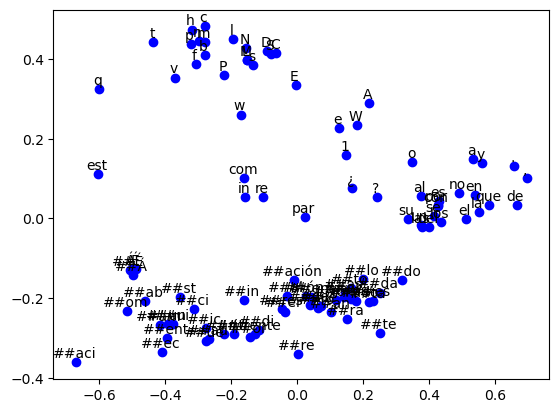

In [7]:
plot_words(embs[1000:1100], list(model_voc.keys())[1000:1100])
plt.show()

## Clasificación

Una de las aplicaciones más comúnes de los modelos encoder-only es la clasificación. Para realizar la clasificación, se hace uso del token especial <tt>[CLS][/tt> y, usualmente, se realiza un ajuste fino. Si bien, se puede realizar una tarea de clasificación sin hacer ajuste fino sobre el modelo de BETO (o BERT); es decir, se puede tomar sólo la salida de este token en el modelo de BETO (que corrresponde a <tt>model.bert</tt>) y entrenar un modelo de clasificación con este vector de entrada. O bien, se puede conectar una red de clasificación a este vector de salida y entrenar ambas redes, lo que se conoce como ajuste fino. Esto entrena no sólo la red de clasificación, sino también los pesos del modelo de BETO, los cuales se ajusgan a la tarea específica.

### Clasificación de opiniones

Para probar las capacidades de clasificación de BETO, utilizamos un dataset para clasificación binaria de opiniones: este dataset se basa en comentarios de la base de datos de películas IMDB, y tiene dos etiquetas "positivo" y "negativo". Este dataset se puede consultar en: 

https://www.kaggle.com/datasets/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish

Para procesar este dataset, primero se tokeniza con el tokenizador de BETO, y se utiliza la función <tt>convert_tokens_to_ids</tt> que lleva cada token a una representación numérica que entrará en la red. Se agrega el token especial <tt>[CLS]</tt> a cada dato para clasificarlo. Además se agrega el padding y se generan los cargadores de datos para entrenar y clasificar.

In [8]:
import pandas as pd
from tqdm import tqdm
from transformers_functions import *

import string

def remove_punctuation_translate(text):
    translator = str.maketrans('', '', string.punctuation)
    
    return text.translate(translator)

#Lectura de los datos de texto
n = 11047
data = pd.read_csv('IMDBSpanish/IMDB Dataset SPANISH.csv', encoding='utf-8')
dataX = [remove_punctuation_translate(w) for w in data['review_es'].tolist()[:n]]
dataY = data['sentimiento'].tolist()[:n]

#Etiquetas
labels = {'negativo':0, 'positivo':1}
y = [labels[l] for l in dataY]

#tokenización y símbolo de clase
x = [torch.tensor(tokenizer.convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(data_i)[:511])) 
          for data_i in dataX]

print(len(x), len(y))

#Cargadores para entrenamiento y test
train_loader, test_loader = get_dataset(x, y, pad=1, batch_size=8)

print(train_loader.dataset.x.shape, train_loader.dataset.y.shape)

11047 11047
torch.Size([7732, 512]) torch.Size([7732])


/home/cienciasia/Documentos/Proyectos/BERT_Prueba/transformers_functions.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(nn.utils.rnn.pad_sequence(x, padding_value=pad)).T #x


### Ajuste fino del modelo

Para entrenar el modelo con los pesos pre-entrenados, utilizamos sólo el módulo de bert del modelo de BETO, y generamos una red de clasificación que toma el vector de clasificación y a partir de este realiza la clasificación. Utilizamos la entropía cruzada y el optimizador Noam. 

In [9]:
classifier = nn.Sequential(nn.Linear(768, 512), nn.ReLU(),
                          nn.Linear(512, len(labels)), nn.Softmax(-1))

model.load_state_dict(torch.load('beto.model', weights_only=True))
classifier.load_state_dict(torch.load('classifier_for_beto.model', weights_only=True))

<All keys matched successfully>

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = NoamOptimizer(list(model.bert.parameters())+list(classifier.parameters()), 768, init_lr=0.01, decay=1e-5, warmup=40000)
epochs = 1

model.bert.train()
classifier.train()
for epoch in range(epochs):
    for xi, yi in tqdm(train_loader):
        optimizer.zero_grad()
        cls = model.bert(xi)[0][:,4]
        output = classifier(cls)
        
        loss = criterion(output, torch.tensor(yi))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

  0%|                                                   | 0/967 [00:00<?, ?it/s]/tmp/ipykernel_5132/1325448251.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(yi))
100%|███████████████████████████████████████| 967/967 [3:29:15<00:00, 12.98s/it]

Epoch 0, Loss: 0.3404


### Evaluación del modelo

Por útlimo, evaluamos el modelo con el dataset para evaluación. Utilizamos <tt>classification_report</tt> para obtener las diferentes métricas de evaluación. Podemos ver que, en general, el desempeño del modelo en esta tarea es adecuado.

In [11]:
from sklearn.metrics import classification_report

model.eval()
classifier.eval()

x_pred = []
y_labels = []
for xi, yi in tqdm(test_loader):
    x_pred += list(classifier(model.bert(xi)[0][:,4]).argmax(1).detach().numpy())
    y_labels += list(yi.numpy())

print(classification_report(x_pred, y_labels, target_names=['negativo', 'positivo']))

100%|█████████████████████████████████████████| 332/332 [22:08<00:00,  4.00s/it]

              precision    recall  f1-score   support

    negativo       0.55      0.98      0.70       951
    positivo       0.99      0.68      0.80      2364

    accuracy                           0.76      3315
   macro avg       0.77      0.83      0.75      3315
weighted avg       0.86      0.76      0.77      3315



In [12]:
torch.save(model.state_dict(), 'beto.model')
torch.save(classifier.state_dict(), 'classifier_for_beto.model')

# Referencias 

Cañete, J., Chaperon, G., Fuentes, R.,Ho, J., Kang, H. y Pérez, J. (2020). <i>Spanish Pre-Trained BERT Model and Evaluation Data</i>. En PML4DC at ICLR 2020.

-------------------------------


<a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/">Principal</a>